In [17]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 18
plt.rc('text', usetex=False)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')

# plt.rc('font', family='Arial', size=12)
# plt.rc('axes', titlesize=16, labelsize=14, grid=True)
plt.rc('lines', linewidth=2)
plt.rc('legend', fontsize=18, frameon=False)
plt.rc('xtick', labelsize=14, direction='in')
plt.rc('ytick', labelsize=14, direction='in')
plt.rc('figure', figsize=(6, 4), dpi=100)

In [18]:
import shutil
import os
import sys

os.chdir('/home/zongchen/nest_bq/results_server/bo/ackley/')
dirs = []
for d in os.listdir('.'):
    dirs.append(d)

print(dirs)

['EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_9', 'EI_look_ahead_mc__dim_2__N_28__kernel_matern__seed_8', 'EI_look_ahead_mc__dim_2__N_28__kernel_matern__seed_2', 'EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_1', 'EI_look_ahead_mc__dim_2__N_28__kernel_matern__seed_0', 'EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_3', 'EI_look_ahead_mc__dim_2__N_28__kernel_matern__seed_19', 'EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_12', 'EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_4', 'EI_look_ahead_mlmc__dim_2__N_28__kernel_matern__seed_17', 'EI_look_ahead_mc__dim_2__N_28__kernel_matern__seed_10', 'EI_look_ahead_mlmc__dim_2__N_28__kernel_matern__seed_16', 'EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_19', 'EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_13', 'EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_11', 'EI_look_ahead_kq__dim_2__N_28__kernel_matern__seed_5', 'EI_look_ahead_mc__dim_2__N_28__kernel_matern__seed_4', 'EI_look_ahead_mc__dim_2__N_28__ker

In [19]:
# Arrays to store the I_nkq and I_nmc values
iter_num = 100
seed_num = len(dirs) / 3
I_nkq_values_array = None
I_nmc_values_array = None
I_mlmc_values_array = None

dim = 2
kernel = 'matern'

# Loop over seed numbers and load data
for d in dirs:
    if 'EI_look_ahead_kq' in d and f'kernel_{kernel}' in d and f'dim_{dim}' in d:
        if I_nkq_values_array is None:
            I_nkq_values_array = np.load(f"{d}/bo_nmse.npy", 'r') 
        else:
            I_nkq_values_array = np.vstack((I_nkq_values_array, np.load(f"{d}/bo_nmse.npy", 'r')))

    if 'EI_look_ahead_mc' in d and f'dim_{dim}' in d:
        if I_nmc_values_array is None:
            I_nmc_values_array = np.load(f"{d}/bo_nmse.npy", 'r')
        else:
            I_nmc_values_array = np.vstack((I_nmc_values_array, np.load(f"{d}/bo_nmse.npy", 'r')))

    if 'EI_look_ahead_mlmc' in d and f'dim_{dim}' in d:
        if I_mlmc_values_array is None:
            I_mlmc_values_array = np.load(f"{d}/bo_nmse.npy", 'r') 
        else:
            try:
                I_mlmc_values_array = np.vstack((I_mlmc_values_array, np.load(f"{d}/bo_nmse.npy", 'r')))
            except:
                pass

# Compute the median and standard deviation
I_nkq_median = np.median(I_nkq_values_array, axis=0)
I_nkq_q25 = np.percentile(I_nkq_values_array, 25, axis=0)
I_nkq_q75 = np.percentile(I_nkq_values_array, 75, axis=0)

I_nmc_median = np.median(I_nmc_values_array, axis=0)
I_nmc_q25 = np.percentile(I_nmc_values_array, 25, axis=0)
I_nmc_q75 = np.percentile(I_nmc_values_array, 75, axis=0)

I_mlmc_median = np.median(I_mlmc_values_array, axis=0)
I_mlmc_q25 = np.percentile(I_mlmc_values_array, 25, axis=0)
I_mlmc_q75 = np.percentile(I_mlmc_values_array, 75, axis=0)


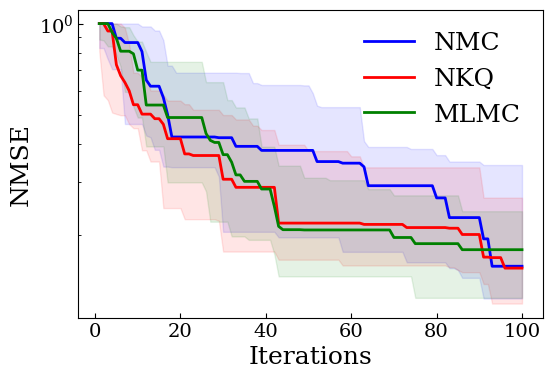

In [20]:
iter_array = np.arange(1, iter_num + 1)

fig1 = plt.figure(figsize=(6, 4))
plt.grid(False)
plt.plot(iter_array, I_nmc_median, label=f'NMC', color='blue')
plt.fill_between(iter_array, I_nmc_q25, I_nmc_q75, alpha=0.1, color='blue')
plt.plot(iter_array, I_nkq_median, label=f'NKQ', color='red')
plt.fill_between(iter_array, I_nkq_q25, I_nkq_q75, alpha=0.1, color='red')
plt.plot(iter_array, I_mlmc_median, label=f'MLMC', color='green')
plt.fill_between(iter_array, I_mlmc_q25, I_mlmc_q75, alpha=0.1, color='green')
plt.xlabel('Iterations')
plt.ylabel('NMSE')
plt.yscale('log')
plt.legend()

